# Additional plots relating to simulated outbreaks

This notebook contains archived code that should not be expected to run without significant tweaks to harmonize with current data structures. It has been used to produce various informative figures to help understand the behavior of growth rates under various epidemiological and demographic conditions.

### Convergence of cumulative cases growth to active cases growth

These plots show how the growth rates in cumulative cases converge to the growth rates in active cases under a S ~= 1 regime (assuming no policy and no noise in $\gamma$).

In [514]:
this_pop = 5e3

In [515]:
this_E0 = 0 / this_pop
this_I0 = 1 / this_pop
this_R0 = 0 / this_pop

out = np.empty(
    (len(LHS_vars), len(gamma_to_test), len(sigma_to_test), ttotal), dtype=np.float32
)
out.fill(np.nan)
coords = OrderedDict(case_type=LHS_vars, gamma=gamma_to_test, sigma=sigma_to_test, t=t)
res_da = xr.DataArray(coords=coords, dims=coords.keys(), data=out).to_dataset(
    dim="case_type"
)
for i in LHS_vars:
    res_da[i + "_logdiff"] = res_da[i].copy()
res_da["S"] = res_da["I"].copy()

# run sim
for gx, gamma in enumerate(gamma_to_test):
    for sx, sigma in enumerate(sigma_to_test):

        # get sample params
        this_beta = beta_deterministic[0, 0, gx, sx] * np.ones(ttotal) / tsteps_per_day
        this_gamma = gamma * np.ones(ttotal) / tsteps_per_day
        this_sigma = sigma * np.ones(ttotal) / tsteps_per_day

        # one policy to adjust to in the middle
        policy_on = int(ttotal / 2)
        beta_pol = beta_deterministic[0, -1, gx, sx] / tsteps_per_day
        this_beta[policy_on:] = beta_pol

        # run dynamic model
        S, E, I, R = epi.run_SEIR(
            ttotal, this_E0, this_I0, this_R0, this_beta, this_gamma, this_sigma
        )
        res_da["S"][gx, sx] = S
        res_da["I"][gx, sx] = I
        res_da["EI"][gx, sx] = I + E
        res_da["IR"][gx, sx] = I + R
        res_da["EIR"][gx, sx] = E + I + R

        for i in LHS_vars:
            a = res_da[i][gx, sx] * this_pop
            a = np.log(a).diff("t", 1)
            a["t"] = t[:-1]
            res_da[i + "_logdiff"][gx, sx, :-1] = a * tsteps_per_day
            res_da[i + "_logdiff"][gx, sx, -1] = np.nan

/Users/ianbolliger/miniconda3/envs/gpl-covid/lib/python3.7/site-packages/xarray/core/computation.py:604: RuntimeWarning: divide by zero encountered in log
  result_data = func(*input_data)


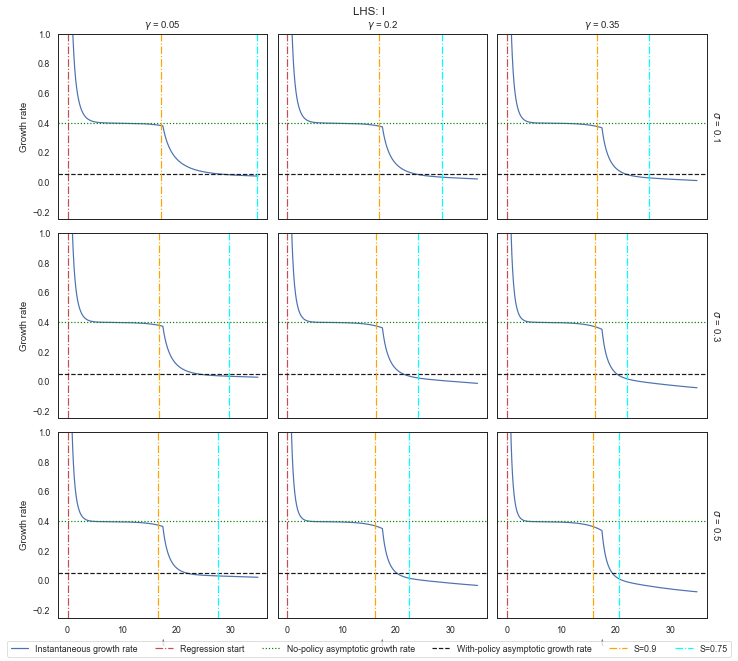

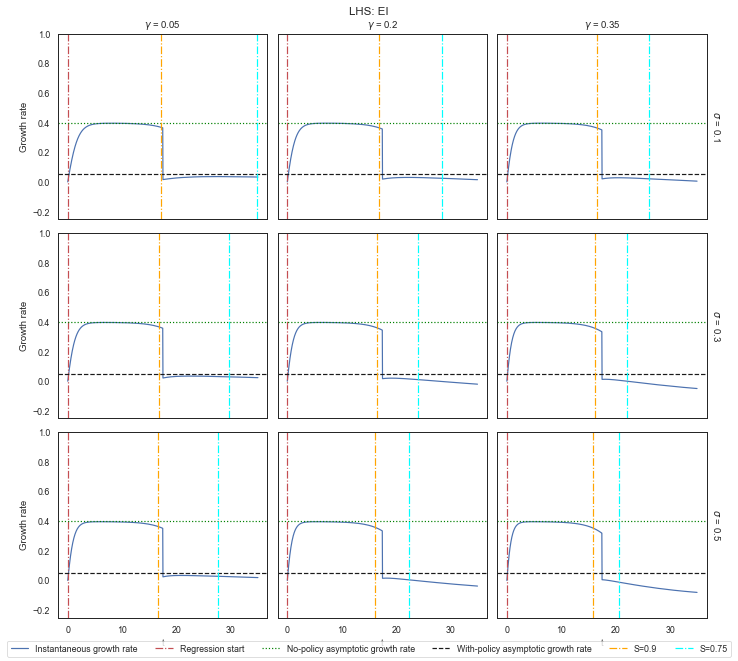

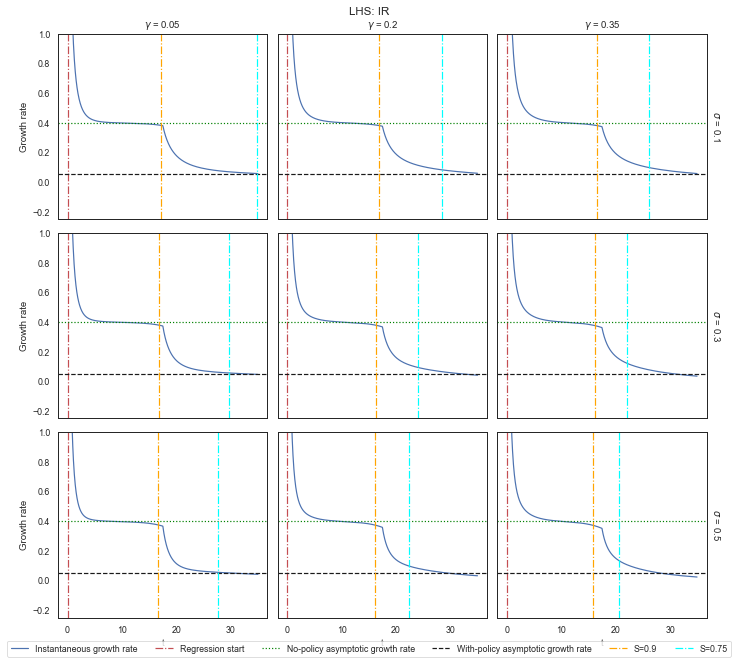

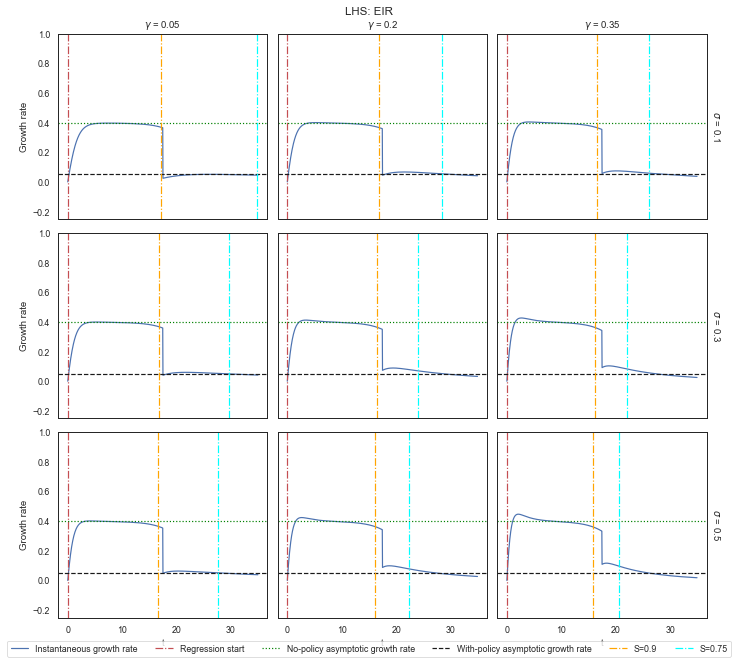

In [531]:
S_da = res_da.S
for case_type in LHS_vars:
    varname = case_type + "_logdiff"
    g = res_da[varname].plot(
        x="t",
        col="gamma",
        row="sigma",
        ylim=(-0.25, 1),
        label="Instantaneous growth rate",
    )
    for ax, namedict in zip(g.axes.flat, g.name_dicts.flat):
        casedata = res_da[case_type].loc[namedict]
        sdata = res_da.S.loc[namedict]
        ax.axvline(
            casedata.t[casedata >= (10 / pop)][0].item(),
            color="r",
            linestyle="-.",
            label="Regression start",
        )
        ax.axhline(
            no_policy_growth_rate,
            color="green",
            linestyle=":",
            label="No-policy asymptotic growth rate",
        )
        ax.axhline(
            no_policy_growth_rate + policy_effects.sum(),
            color="k",
            linestyle="--",
            label="With-policy asymptotic growth rate",
        )
        ax.axvline(
            sdata.t[sdata <= 0.9][0].item(),
            color="orange",
            linestyle="-.",
            label="S=0.9",
        )
        ax.axvline(
            sdata.t[sdata <= 0.75][0].item(),
            color="cyan",
            linestyle="-.",
            label="S=0.75",
        )
    g.fig.legend(
        *g.axes.flat[0].get_legend_handles_labels(), loc="lower center", ncol=6
    )
    g.set_titles("$\{coord}$ = {value}")
    g.set_ylabels("Growth rate")
    g.fig.suptitle(f"LHS: {case_type}", va="bottom", y=0.99)
    g.fig.savefig(
        out_dir / f"growth_sim_{case_type}_pop_{this_pop}.pdf",
        dpi=300,
        tight_layout=True,
    )